In [1]:
#Code Referenced from pytorch tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


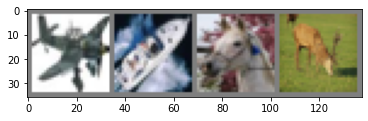

plane  ship horse  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
times = []
accuracy_scores = []
networks = ["CNN2", "CNN3", "CNN4", "CNN4Large", "CNN3Large"]

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import time


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
def train(epochs):
  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0

  print('Finished Training')

start = time.time()
train(2)
end = time.time()
times.append(end-start)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.168
[1,  4000] loss: 1.809
[1,  6000] loss: 1.626
[1,  8000] loss: 1.551
[1, 10000] loss: 1.499
[1, 12000] loss: 1.447
[2,  2000] loss: 1.385
[2,  4000] loss: 1.372
[2,  6000] loss: 1.360
[2,  8000] loss: 1.325
[2, 10000] loss: 1.300
[2, 12000] loss: 1.301
Finished Training


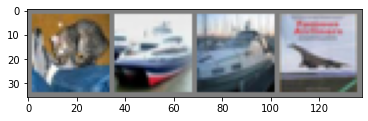

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  ship   car plane


In [13]:
def test():
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          # calculate outputs by running images through the network 
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy_scores.append(100 * correct/total)
  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  
test()

Accuracy of the network on the 10000 test images: 54 %


In [14]:
def accuracy_by_class():
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for data in testloader:
          images, labels = data    
          outputs = net(images)    
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

    
  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                    accuracy))
      
#All code above referenced from pytorch tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

accuracy_by_class()

Accuracy for class plane is: 70.3 %
Accuracy for class car   is: 79.6 %
Accuracy for class bird  is: 53.7 %
Accuracy for class cat   is: 38.7 %
Accuracy for class deer  is: 31.1 %
Accuracy for class dog   is: 36.9 %
Accuracy for class frog  is: 76.4 %
Accuracy for class horse is: 47.8 %
Accuracy for class ship  is: 63.6 %
Accuracy for class truck is: 50.1 %


In [15]:
class ThreeLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ThreeLayerNet()

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
start = time.time()
train(2)
end = time.time()
times.append(end-start)

[1,  2000] loss: 2.290
[1,  4000] loss: 2.021
[1,  6000] loss: 1.805
[1,  8000] loss: 1.669
[1, 10000] loss: 1.548
[1, 12000] loss: 1.465
[2,  2000] loss: 1.383
[2,  4000] loss: 1.341
[2,  6000] loss: 1.324
[2,  8000] loss: 1.292
[2, 10000] loss: 1.241
[2, 12000] loss: 1.236
Finished Training


In [18]:
test()

Accuracy of the network on the 10000 test images: 57 %


In [19]:
accuracy_by_class()

Accuracy for class plane is: 65.2 %
Accuracy for class car   is: 77.2 %
Accuracy for class bird  is: 34.4 %
Accuracy for class cat   is: 23.6 %
Accuracy for class deer  is: 50.7 %
Accuracy for class dog   is: 59.7 %
Accuracy for class frog  is: 72.7 %
Accuracy for class horse is: 54.9 %
Accuracy for class ship  is: 77.8 %
Accuracy for class truck is: 63.6 %


In [20]:
class FourLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = (F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = FourLayerNet()

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
start = time.time()
train(2)
end = time.time()
times.append(end-start)

[1,  2000] loss: 2.304
[1,  4000] loss: 2.294
[1,  6000] loss: 2.043
[1,  8000] loss: 1.833
[1, 10000] loss: 1.672
[1, 12000] loss: 1.569
[2,  2000] loss: 1.490
[2,  4000] loss: 1.430
[2,  6000] loss: 1.376
[2,  8000] loss: 1.340
[2, 10000] loss: 1.289
[2, 12000] loss: 1.245
Finished Training


In [23]:
test()

Accuracy of the network on the 10000 test images: 55 %


In [24]:
accuracy_by_class()

Accuracy for class plane is: 34.0 %
Accuracy for class car   is: 73.9 %
Accuracy for class bird  is: 28.4 %
Accuracy for class cat   is: 32.0 %
Accuracy for class deer  is: 60.1 %
Accuracy for class dog   is: 45.4 %
Accuracy for class frog  is: 84.8 %
Accuracy for class horse is: 60.5 %
Accuracy for class ship  is: 70.6 %
Accuracy for class truck is: 64.0 %


In [25]:
class FourLayerLargeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = (F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



net = FourLayerLargeNet()

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [27]:
start = time.time()
train(2)
end = time.time()
times.append(end-start)

[1,  2000] loss: 2.299
[1,  4000] loss: 2.079
[1,  6000] loss: 1.862
[1,  8000] loss: 1.662
[1, 10000] loss: 1.571
[1, 12000] loss: 1.514
[2,  2000] loss: 1.410
[2,  4000] loss: 1.369
[2,  6000] loss: 1.321
[2,  8000] loss: 1.267
[2, 10000] loss: 1.247
[2, 12000] loss: 1.175
Finished Training


In [28]:
test()

Accuracy of the network on the 10000 test images: 58 %


In [29]:
accuracy_by_class()

Accuracy for class plane is: 68.6 %
Accuracy for class car   is: 72.7 %
Accuracy for class bird  is: 53.7 %
Accuracy for class cat   is: 33.4 %
Accuracy for class deer  is: 38.1 %
Accuracy for class dog   is: 59.9 %
Accuracy for class frog  is: 48.5 %
Accuracy for class horse is: 76.8 %
Accuracy for class ship  is: 63.8 %
Accuracy for class truck is: 73.6 %


In [33]:
class ThreeLayerLargeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128, 5)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ThreeLayerLargeNet()

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [35]:
start = time.time()
train(2)
end = time.time()
times.append(end-start)

[1,  2000] loss: 2.200
[1,  4000] loss: 1.832
[1,  6000] loss: 1.658
[1,  8000] loss: 1.525
[1, 10000] loss: 1.420
[1, 12000] loss: 1.361
[2,  2000] loss: 1.278
[2,  4000] loss: 1.212
[2,  6000] loss: 1.151
[2,  8000] loss: 1.134
[2, 10000] loss: 1.082
[2, 12000] loss: 1.053
Finished Training


In [36]:
test()

Accuracy of the network on the 10000 test images: 63 %


In [37]:
accuracy_by_class()

Accuracy for class plane is: 61.6 %
Accuracy for class car   is: 72.1 %
Accuracy for class bird  is: 49.9 %
Accuracy for class cat   is: 37.2 %
Accuracy for class deer  is: 57.7 %
Accuracy for class dog   is: 73.3 %
Accuracy for class frog  is: 69.6 %
Accuracy for class horse is: 65.7 %
Accuracy for class ship  is: 85.9 %
Accuracy for class truck is: 61.6 %


In [38]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [40]:
net = ThreeLayerLargeNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

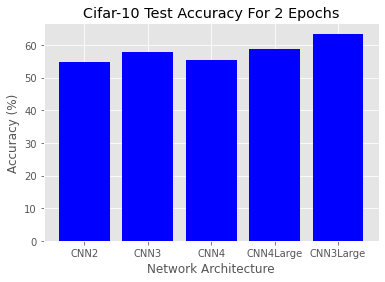

In [45]:
#plotting code referenced from https://benalexkeen.com/bar-charts-in-matplotlib/
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

x_pos = [i for i, _ in enumerate(networks)]

plt.bar(x_pos, accuracy_scores, color='blue')
plt.xlabel("Network Architecture")
plt.ylabel("Accuracy (%)")
plt.title("Cifar-10 Test Accuracy For 2 Epochs")

plt.xticks(x_pos, networks)

plt.show()

In [49]:
times_mins = []
for x in range(len(times)):
  temp = times[x]/60
  times_mins.append(temp)
times_mins

[2.126092851161957,
 3.282284982999166,
 6.373697070280711,
 23.43033141295115,
 15.452021066347758]

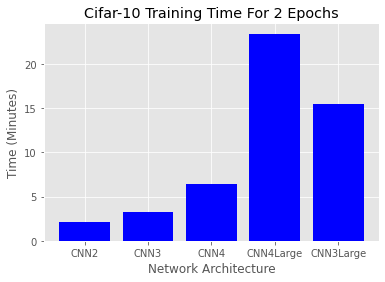

In [50]:
#plotting code referenced from https://benalexkeen.com/bar-charts-in-matplotlib/
plt.style.use('ggplot')

x_pos = [i for i, _ in enumerate(networks)]

plt.bar(x_pos, times_mins, color='blue')
plt.xlabel("Network Architecture")
plt.ylabel("Time (Minutes)")
plt.title("Cifar-10 Training Time For 2 Epochs")

plt.xticks(x_pos, networks)

plt.show()